<a href="https://colab.research.google.com/github/silasabs/CoherentOptics/blob/main/examples/7.%20Clock%20Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, pnorm, upsample, phaseNoise, decimate
from optic.models.devices import iqm, coherentReceiver
from optic.models.channels import linearFiberChannel
from optic.utils import parameters
from optic.comm.metrics import fastBERcalc
from optic.comm.modulation import modulateGray
from optic.models.devices import adc
from optic.plot import pconst

import scipy.constants as const

# Clock Recovery

Os sistemas de comunicação digital processam amostras digitalizadas de formas de onda analógicas. Essas amostras devem ser coletadas em instantes específicos de tempo, e imperfeições nesse processo podem prejudicar significativamente a transmissão de dados. 

Erros de temporização podem ser classificados em erros de fase de amostragem e erros de frequência de amostragem. Erros de fase de amostragem aparecem quando a frequência do relógio do receptor é sincronizada com precisão com a frequência do relógio do transmissor, mas há um atraso constante com relação aos instantes de amostragem ideais. 

Em sistemas com erros de frequência de amostragem, os instantes de amostragem ideais variam ao longo do tempo, levando a uma resposta de frequência variável no tempo que não pode ser rastreada indefinidamente. Portanto, algoritmos de recuperação de clock, que corrigem adaptativamente erros de amostragem de frequência, são de fundamental importância.

## 7.1 Clock Recovery Architectures

Os esquemas de recuperação de relógio em sistemas digitais podem ser classificados de acordo com sua arquitetura em três categorias:

- **Esquemas analógicos:** Em um esquema puramente analógico, um circuito de entrada analógico extrai informações de tempo do sinal e atua diretamente. Tais estruturas de recuperação de relógio analógico não são usadas em receptores ópticos coerentes digitais, pois a detecção de erro de tempo pode ser implementada efetivamente no domínio digital.

<br>
<center>
    <img src="https://i.postimg.cc/4xHQqpC4/Screenshot-from-2024-10-04-18-21-31.png" width="900">
</center>
</br>

- **Esquemas Híbridos:** No esquema híbrido, o sinal recebido é amostrado e processado no domínio digital para extrair informações de tempo. Essas informações são então usadas para atuar no relógio de amostragem.

<br>
<center>
    <img src="https://i.postimg.cc/GmbsJYcS/Screenshot-from-2024-10-04-18-26-01.png" width="900">
</center>
</br>

- **Esquemas Digitais:** No esquema puramente digital, a extração do sinal de relógio, bem como os ajustes de tempo de amostragem são feitos de forma puramente digital.

<br>
<center>
    <img src="https://i.postimg.cc/N0SMVrct/Screenshot-from-2024-10-04-18-27-15.png" width="900">
</center>
</br>

Existem várias alternativas viáveis ​​para implementar a recuperação de relógio em sistemas ópticos coerentes digitais, incluindo esquemas híbridos analógico-digitais, esquemas puramente digitais ou uma combinação de ambos. Uma solução comum combina
um esquema híbrido analógico-digital para ajustes de tempo grosseiros e um esquema puramente digital para ajustes finos de tempo.

## Implementações nos domínios do tempo e frequência

Algoritmos de recuperação de clock podem ser implementados no domínio do tempo ou frequência. Algoritmos no domínio de frequência podem ser vantajosos do ponto de vista da complexidade se a cadeia de algoritmos DSP já implementa transformadas rápidas de Fourier (FFTs) e transformadas rápidas de Fourier inversas (IFFTs) para outras aplicações, como a compensação da dispersão cromática, evitando operações repetidas.

Um esquema híbrido típico de domínio de frequência implantado em sistemas de comunicações ópticas é mostrado abaixo. Um sinal de detector de erro de temporização (TED) é obtido no domínio de frequência após o sinal ser multiplicado pelo filtro de compensação CD, mas antes do IFFT.

<br>
<center>
    <img src="https://i.postimg.cc/DyTcHSv1/Screenshot-from-2024-10-04-18-44-55.png">
</center>
</br>

A saída do TED fornece um sinal de controle que, após a filtragem no filtro de loop (LF), é capaz de controlar o oscilador controlado por tensão (VCO) que atua nos ADCs. Um esquema puramente digital típico de domínio de tempo é mostrado abaixo.

O sinal de entrada $x(t)$ é primeiramente amostrado pelo ADC a uma taxa de amostragem fixa $1/Ta$ , onde $Ta$ é o período de amostragem. Assim, um sinal digitalizado de tempo discreto, com amostras $x[m] = x(mTa)$, é produzido na saída do ADC. O sinal digital é então encaminhado para um interpolador, que amostra o sinal nos tempos de amostragem desejados.

<br>
<center>
    <img src="https://i.postimg.cc/mkG7vnsT/Screenshot-from-2024-10-04-18-53-12.png">
</center>
</br>

A saída do interpolador gera amostras com taxa $1/T_I$ . Idealmente, como sistemas ópticos coerentes digitais trabalham com equalizadores $Ts/2$ espaçados fracionadamente, $T_I = Ts/2$. O caminho de feedback começa com um TED, fornecendo um sinal de controle que, após o LF, é capaz de controlar um oscilador controlado numericamente (NCO). A saída do NCO atua no interpolador, fechando o loop de fase digital (DPLL). Várias outras combinações também são possíveis, por exemplo, com recuperação de clock puramente digital no domínio da frequência.

## 7.2 Interpolador

Em esquemas de recuperação de clock puramente digitais, o propósito da interpolação é obter uma amostra da forma de onda do sinal em um determinado instante, com base em amostras coletadas em instantes vizinhos. 

<br>
<center>
    <img src="https://i.postimg.cc/XqptPxwN/Screenshot-from-2024-10-04-20-44-12.png">
</center>
</br>

Um conjunto de amostras de entrada espaçadas em $T_a$, indicadas na parte superior da figura, são usadas para gerar a amostra de saída no instante $nT_I$ . O processo é baseado na interpolação de uma amostra localizada em um intervalo fracionário $\mu_n T_a$ , tendo como ponto base uma amostra no instante $m_n T_a$ , onde $m_n = \frac{kT_I}{T_a}$. 
A interpolação já foi discutida no [Cap. 4](https://github.com/silasabs/CoherentOptics/blob/main/examples/4.%20Coherent%20Receiver%20Front-End.ipynb), no escopo da compensação de inclinação. A recuperação de clock usa algoritmos semelhantes, que são baseados em filtros lineares transversais. No entanto, diferentemente da compensação de inclinação, o esquema de recuperação de clock ajusta os coeficientes do filtro dinamicamente, símbolo por símbolo, com base na saída de um NCO. 


A interpolação pode ser implementada no domínio da frequência junto com a compensação de CD, ou usando um interpolador de domínio de tempo. Uma solução popular no domínio do tempo usa um interpolador cúbico de Lagrange. Os interpoladores cúbicos podem ter de 4 a 10 taps com banda passante crescente. Os coeficientes de um interpolador cúbico de 4 taps, para um instante de interpolação $t = m_nT_a + \mu_n T_a$ , são fornecidos por [2].

$$w_{n-2}\;=\;-\,{\frac{1}{6}}\mu_{n}^{3}+\,{\frac{1}{6}}\mu_{n};$$

$$w_{n-1}\;=\;\frac{1}{2}\mu_{n}^{3}+\frac{1}{2}\mu_{n}^{2}-\mu_{n};$$

$$w_{n}\;=\;-\,\frac{1}{2}\mu_{n}^{3}-\mu_{n}^{2}+\frac{1}{2}\mu_{n}+1;$$

$$w_{n+1}\;=\;{\frac{1}{6}}\mu_{n}^{3}+{\frac{1}{2}}\mu_{n}^{2}+{\frac{1}{3}}\mu_{n}.$$

Atualizar os coeficientes do filtro para cada intervalo fracionário $\mu_n$ exigiria o cálculo e a transferência de quatro coeficientes. Alternativamente, a estrutura de interpolação proposta por Farrow em [3] requer a transferência de uma única variável  $\mu_n$ , ao custo de uma estrutura de filtro mais complexa.

In [2]:
def interpolator(x, mu):
    """
    Interpolador cúbico baseado na estrutura de Farrow

    Parameters
    ----------
    x : np.array
        matriz de 4 elementos para interpolação cúbica.
    
    mu : float
        parâmetro de interpolação.

    Returns
    -------
    y : float
        sinal interpolado.
    
    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms
        
        [2] C. Farrow, A continuously variable digital delay element, in IEEE International Symposium on Circuits and Systems, vol. 3 (1988), pp. 2641–2645
    """
    
    return (
        x[0] * (-1/6 * mu**3 + 1/6 * mu) +
        x[1] * (1/2 * mu**3 + 1/2 * mu**2 - mu) +
        x[2] * (-1/2 * mu**3 - mu**2 + 1/2 * mu + 1) +
        x[3] * (1/6 * mu**3 + 1/2 * mu**2 + 1/3 * mu)
    )

## 7.3 Timing Error Detector

O TED extrai informações de tempo e as encaminha, após filtragem, para um VCO ou NCO. Este processo é realizado em malha fechada, construindo o chamado loop de fase bloqueada (PLL). Talvez o esquema TED mais utilizado seja o proposto por Gardner em [4]. Tomando três amostras vizinhas espaçadas em $Ts/2$ do sinal recebido $x[2k − 2], x[2k − 1]$ e $x[2k]$, assumidas como reais por uma questão de simplicidade, o algoritmo de Gardner calcula o sinal de indicação de erro de tempo espaçado em $Ts$ como:

$$e[k]=x[n-1](x[n]-x[n-2]),\ \ n=2k.$$

<br>
<center>
    <img src="https://i.postimg.cc/D0cSq3cW/Screenshot-from-2024-10-05-21-05-12.png">
</center>
</br>

- Figura (a): $\Delta\tau = 0$ (Tempo de amostragem correto)
- Figura (b): $\Delta\tau > 0$ (Amostragem tardia)
- Figura (c): $\Delta\tau < 0$ (Amostragem precoce)

O princípio básico do Gardner TED é descrito acima para um sinal BPSK. Os três círculos laranjas indicam as amostras de entrada usadas pelo algoritmo. Três casos são indicados. Em cada um desses casos temos, respectivamente,

$$e[k]=0\cdot(1-(-1))=0;$$
$$e[k]=0.2\cdot(0.8-(-0.8))=0.32\gt 0;$$
$$e[k]=-0.2\cdot(0.8-(-0.8))=-0.32\lt 0.$$

Se o sinal de entrada for amostrado na fase correta, a amostra central coincide com as transições, e o sinal de erro vai idealmente para zero. Se a fase de amostragem for tardia, a amostra central tem um valor positivo, e o sinal de $e[k]$ é positivo. Se, no entanto, a fase de amostragem for muito precoce, a amostra central tem um valor negativo, e o sinal de $e[k]$ é negativo. Portanto, o valor absoluto de $e[k]$ dá uma indicação da magnitude da incompatibilidade da fase de amostragem, enquanto seu sinal indica se a fase de amostragem é precoce ou tardia. Embora à primeira vista o algoritmo de Gardner pareça corrigir apenas erros de amostragem de fase, sua operação contínua e os ajustes feitos ao longo do tempo fornecem uma correção substancial para erros de amostragem de frequência.

Em sistemas com modulação em fase e em quadratura, o TED pode combinar ambos os componentes como:

$$\begin{array}{c}{{e[k]=x^{I}[n-1]\left(x^{I}[n]-x^{I}[n-2]\right)+x^{Q}[n-1]\left(x^{Q}[n]-x^{Q}[n-2]\right)}}\end{array}$$

$$\begin{array}{c}{{=\Re\left\{x^{*}[n-1]\left(x[n]-x[n-2]\right)\right\}, n = 2k.}}\end{array}$$

Conforme discutido anteriormente, desvios no instante de amostragem correto $\Delta\tau$ causam um aumento na magnitude da saída $e[k]$, e seu sinal indica um tempo de amostragem tardio ou precoce. O TED de Gardner requer transições bem definidas entre símbolos adjacentes, mas sistemas coerentes digitais ópticos são fortemente afetados por efeitos dispersivos.

Algoritmos TED de domínio de tempo são geralmente aplicados após o filtro de compensação CD, resolvendo metade do problema. A questão então é se é mais apropriado implementá-lo antes ou depois do filtro de compensação PMD adaptativo borboleta. Implementá-lo antes da compensação PMD, preserva o equalizador de mudanças estocásticas devido a variações de clock. Por outro lado, alguns casos patológicos de PMD podem fazer o sinal de clock desaparecer, deteriorando o desempenho do sistema.

Uma possível solução para esse problema é desfazer a rotação de polarização realizada pelo canal combinando os sinais das orientações V e H, mas essa estratégia requer um loop de rastreamento para o ângulo de rotação. Além disso, os efeitos de canal relacionados à polarização podem ser mais complicados do que um único elemento de atraso de grupo diferencial (DGD). Embora o TED de Gardner tenha um desempenho satisfatório com pulsos NRZ e RZ, ele é fortemente prejudicado por pulsos Nyquist com pequenos fatores de roll-off. O algoritmo proposto em [5] implementa um TED Gardner (MG) modificado com base na potência
dos símbolos equalizados. A saída MG TED é dada por:

$$e[k]=y[n-1]y[n-1]^{*}\left(y[n-2]y[n-2]^{*}-y[n]y[n]^{*}\right),\;\;n=2k$$

In [3]:
def gardnerTED(x, isNyquist):
    """
    Gardner TED algorithm.

    Parameters
    ----------
    x : np.array
        Matriz de três amostras para o calculo do erro.

    pulseType : bool
        sinaliza um pulso da família de Nyquist.

    Returns
    -------
    error: float
        magnitude do erro.
    
    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms

        [2] F. Gardner, A BPSK/QPSK timing-error detector for sampled receivers. IEEE Trans. Commun. 34(5), 423–429 (1986)
    """ 
    if isNyquist:
        return np.abs(x[1]) ** 2 * (np.abs(x[0]) ** 2 - np.abs(x[2]) ** 2)
    else:
        return np.real(np.conj(x[1]) * (x[2] - x[0]))

## Timing Error Detector (Frequency Domain)

Implementar o TED no domínio da frequência pode economizar complexidade se a cadeia de algoritmos DSP já usa FFTs/IFFTs para outras operações, por exemplo, para compensação de CD. Uma solução eficaz é o Godard TED, dado por Godard [6]

$$e[k]=\sum_{n=0}^{N/2-1}\mathrm{Im}\{X[n]\cdot X^{*}[n+N/2])\}$$

Onde $X[n]$ é a FFT de $x[n]$. Coletar $X[n]$ dentro do filtro de equalização CD economiza complexidade adicional, mas uma eventual perda de tom de clock por causa de PMD ainda pode surgir. Embora o Godard TED tenha sido criado para amostras $Ts/2$-espaçadas, ele também pode ser adaptado para operar com taxas de amostragem mais baixas para reduzir a complexidade.

O algoritmo de Godard multiplica os componentes de frequência positiva com o conjugado complexo dos componentes de frequência negativa. Saiba que o espectro DFT é N periódico, de modo que os coeficientes $X_{n+N/2}$ e $X_{n−N/2}$ são iguais.

In [98]:
def godardTED(blockFFT, NFFT):
    """
    Godard TED algorithm

    Parameters
    ----------
    blockFFT : np.array
        Bloco FFT a ser processado.

    NFFT : int
        Comprimento do bloco 'N'.

    Returns
    -------
    float
        Estimativa do erro para o respectivo bloco.
    """
    return np.sum(np.imag(blockFFT[:NFFT//2] * np.conj(blockFFT[NFFT//2:])))/NFFT

## Plot S-Curve

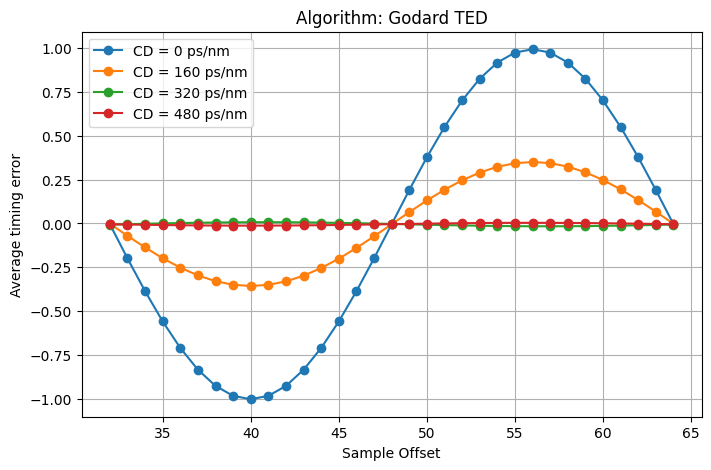

In [ ]:
'''
Script simples para obter a curva S de um determinado TED 
'''

plotScuve = True
ted = 'godard'

# Transmitter parameters
M = 16                  # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'nrz'        # Pulso a ser utilizado
Rs = 32e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.01            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2
paramIQM.Vb = -paramIQM.Vπ

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 100          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]
paramFiber.Fc = 193.1e12    # Hz

D = [0, 1.6, 3.2, 4.8] # parâmetro de dispersão [ps/nm/km]

offsets = np.arange(SpS, 2*SpS+1)
average = np.zeros((len(offsets), len(D)), dtype='float')

for index, CD in enumerate(D):
    
    paramFiber.D = CD
    
    bitsTx = np.random.randint(2, size = int(1e5*np.log2(M)))

    symbTx = modulateGray(bitsTx, M, constType)
    symbTx = pnorm(symbTx) # symbol power normalization

    symbolsUp = upsample(symbTx, SpS)

    if pulseType == "nrz" or pulseType == "rect":
        pulse = pulseShape(pulseType, SpS)
    elif pulseType == "rrc":
        pulse = pulseShape("rrc", SpS, Ncoeff, alpha, Ts)

    pulse = pulse/max(abs(pulse))
    sigTx = firFilter(pulse, symbolsUp)

    # Laser power
    Pi = 100e-3  # potência óptica do laser na entrada do IQM

    # optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

    # canal óptico linear
    sigRxo = linearFiberChannel(sigTxo, paramFiber)

    # parâmetros do receptor
    B = 32e9            # banda do receptor em Hz
    Plo_dBm  = 10       # potência do oscilador local
    Δf_lo    = 0        # desvio de frequência do oscilador local
    ϕ_lo     = 0        # fase do oscilador local
    lw       = 100      # laser linewidth Hz

    Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

    # oscilador local
    t = np.arange(0, sigRxo.size)*Ta
    ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

    sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

    sigRx_ = coherentReceiver(sigRxo, sigLO)
    sigRx = firFilter(pulse, sigRx_)

    for idx, offset in enumerate(offsets):
        
        # Decime para duas amostras por símbolo e aplique um atraso ao sinal
        sigRxOffset = sigRx[offset::int(SpS/2)]

        if ted == "gardner":
            late = sigRxOffset[2:]
            early = sigRxOffset[:-2]
            prompt = sigRxOffset[1:-1]
            
            # Gardner TED
            average[idx, index] = np.mean(np.real(np.conj(prompt[::2]) * (late - early)[::2]))
            
        elif ted == "gardnerNyquist":
            late = sigRxOffset[2:]
            early = sigRxOffset[:-2]
            prompt = sigRxOffset[1:-1]

            # Gardner TED para Pulsos de Nyquist
            average[idx, index] = np.mean(np.abs(prompt[::2]) ** 2 * (np.abs(early[::2]) ** 2 - np.abs(late[::2]) ** 2))
            
        elif ted == "godard":
            
            NFFT = 2048
            
            num_blocks = len(sigRxOffset) // NFFT
            errors = []

            for block_idx in range(num_blocks):
                
                # Extraia o bloco FFT
                start = block_idx * NFFT
                end = start + NFFT
                
                blk = sigRxOffset[start:end]

                # FFT do bloco
                blkFFT = np.fft.fft(blk, NFFT)

                # Calcular o erro usando Godard TED
                error = godardTED(blkFFT, NFFT)
                errors.append(error)

            average[idx, index] = np.mean(errors)
        
        else:
            raise ValueError('TED especificado incorretamente.')
        
if plotScuve:
    plt.figure(figsize=(8, 5))
    for index, dispersion in enumerate(D):
        plt.plot(offsets, average[:, index][::-1], '-o', label=f'CD = {int(dispersion*paramFiber.L)} ps/nm')
    plt.title(f'Algorithm: {str(ted[0]).upper() + str(ted[1:])} TED')
    plt.xlabel('Sample Offset')
    plt.ylabel('Average timing error')
    plt.legend()
    plt.grid()

## 7.5 Numerically Controlled Oscillator

Na recuperação de relógio puramente digital, o sinal de controle filtrado fornecido pelo LF é enviado ao NCO, que produz os sinais de intervalo fracionário e underflow que alimentam o interpolador, completando o DPLL. O sinal oscilante produzido pelo NCO é a saída de um operador mod-1

$$\eta_{m_{n}}^{\mathrm{NCO}}=\left[\eta_{m_{n}-1}^{\mathrm{NCO}}-W[k]\right]_{\mathrm{mod-1}}$$

onde $W[k]$ é a saída LF no momento da amostra de entrada $m_n$ . O operador $mod-1$ é igual ao resto de uma divisão por 1. Na divisão, o quociente pode ser zero, positivo e negativo, enquanto o resto está sempre no intervalo [0, 1). Por exemplo, se o argumento for 0,8, a operação de módulo produz 0,8 (o quociente é 0 e o resto é 0,8). Se o argumento for −0,8, a operação de módulo produz 0,2 (o quociente é −1 e o resto é 0,2). 

Quando o intervalo de interpolação $T_I$ atinge exatamente o período do símbolo $T_s$, a saída TED se torna 0. Consequentemente, o braço proporcional LF se torna 0 e o braço integral para de acumular, gerando uma saída constante $W[k]$. Nessas condições, o NCO diminui em $W[k]$ a cada $T_a$ segundos, fazendo com que o NCO sofra um subfluxo em média após $1/W[k]$ ciclos de clock. O período $T_I$ do NCO é exatamente o período entre underflows.



## Time Domain Clock Recovery 

In [39]:
def clockRecovery(x, paramCR):
    """
    Executa a recuperação de clock no sinal 'x' usando uma estrutura DPLL 
    consistindo em um interpolador, um TED, um filtro de loop e um NCO. 

    Parameters
    ----------
    x : np.array
        sinal de entrada com duas orientações de polarização obtido em 2 Sa/Símbolo.
    
    paramCR : struct

        - paramCR.ki (float): Constante da parte integral do filtro de loop. (ganho integrativo)

        - paramCR.kp (float): Constante da parte proporcional do filtro de loop. (ganho proporcional)

        - paramCR.Nyquist (bool): Sinaliza um pulso de Nyquist.

        - paramCR.nSymbols (int): Número de símbolos transmitidos.

        - paramCR.ppm (int): Desvio esperado da taxa máxima de clock. [ppm]

    Returns
    -------
    tuple
        - y (np.array): Sinal obtido após a recuperação do clock.
        - ted_values (np.array): O sinal oscilante produzido pelo NCO.

    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms
        
        [2] C. Farrow, A continuously variable digital delay element, in IEEE International Symposium on Circuits and Systems, vol. 3 (1988), pp. 2641–2645

        [3] F. Gardner, A BPSK/QPSK timing-error detector for sampled receivers. IEEE Trans. Commun. 34(5), 423–429 (1986)
    """

    length, nModes = x.shape
    nSymbols = paramCR.nSymbols

    y = np.zeros((int((1 - paramCR.ppm / 1e6) * length), nModes), dtype="complex")

    # obtenha o sinal produzido pelo NCO
    nco_values = np.zeros(x.shape, dtype="float")
    y[:2] = x[:2]
    
    for indMode in range(nModes):
        
        # parâmetros do dpll:
        out_nco = 0.5           
        out_LF  = 1             
        
        n = 2
        fractional_interval = 0     # mun                  
        basePoint = n               # mn                     
        
        integrative = out_LF 

        while n < length - 1 and basePoint < length - 2:
            y[n, indMode] = interpolator(x[basePoint - 2: basePoint + 2, indMode], fractional_interval)

            if n % 2 == 0:
                # obtenha o erro de tempo 
                errorTED = gardnerTED(y[n - 2: n + 1, indMode], paramCR.Nyquist)
                
                # loop PI filter
                integrative += paramCR.ki * errorTED
                proportional = paramCR.kp * errorTED
                out_LF = proportional + integrative

            eta_nco = out_nco - out_LF

            if eta_nco > -1 and eta_nco < 0:
                basePoint += 1 # Neste caso, a próxima amostra mn+1 é usada como ponto base para a próxima atualização do interpolador
            elif eta_nco >= 0:
                basePoint += 2 # Neste caso, uma amostra é ignorada e a outra amostra é usada como ponto base para a próxima atualização do interpolador.

            out_nco = eta_nco % 1
            fractional_interval = out_nco / out_LF
            
            nco_values[n, indMode] = eta_nco

            # atualiza o indexador temporal 'n'   
            n += 1
        
    if nSymbols * 2 < len(y):
        return y[0:nSymbols * 2, :], nco_values
    else:    
        return y, nco_values

## Teste algoritmos de recuperação de clock

Esta simulação transmite um sinal com duas orientações de polarização sendo digitalizado por um ADC para emulação do desvio de clock resultando em um desvio correspondente na taxa de amostragem do ADC.

ADC sampling rate = 63.98720 GS/s
ADC sampling clock drift (ΔFs) = -200.00 ppm


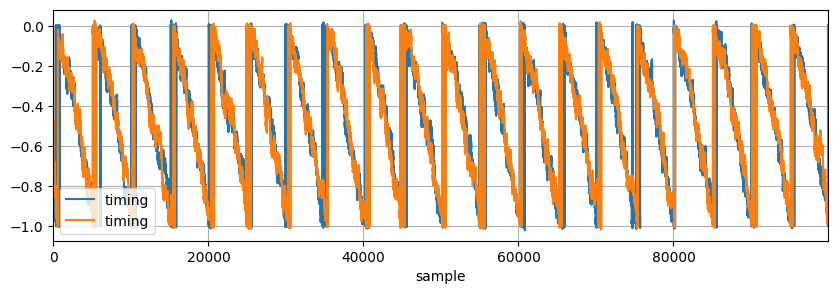

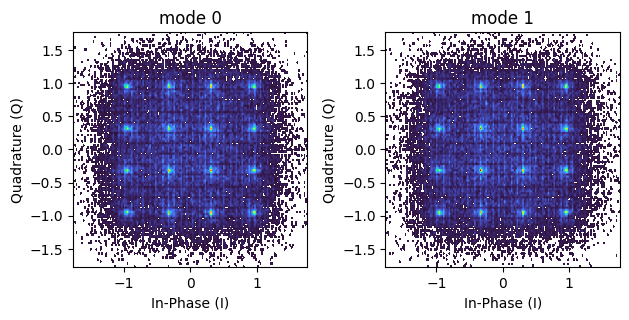

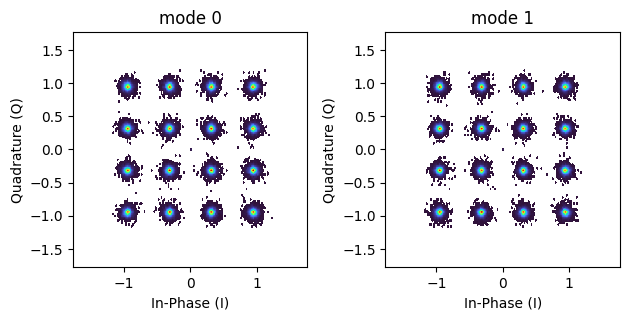

Mode 0: BER = 1.25e-05
Mode 1: BER = 0.00e+00


In [40]:
# simulation parameters
SpS = 16          # samples per symbol
M = 16            # order of the modulation format
Rs = 32e9         # Symbol rate 
Fs = SpS*Rs       # Sampling frequency in samples/second
Ts = 1/Fs         # Sampling period
ppm = -200        # Deviation of the ADC sampling rate in ppm

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*1e5))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization
symbTx = symbTx.reshape(-1,2)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rc', SpS, N=4001, alpha=0.01)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# Calculate ADC sampling rate from clock ppm deviation
Fs_adc = 2*Rs*(1 + ppm/1e6)
ppm_meas = (Fs_adc-2*Rs)/(2*Rs)*1e6
print(f'ADC sampling rate = {Fs_adc/1e9:.5f} GS/s')
print(f'ADC sampling clock drift (ΔFs) = {ppm_meas:.2f} ppm')

# ADC input parameters
paramADC = parameters()
paramADC.Fs_in = Fs
paramADC.Fs_out = Fs_adc
paramADC.jitter_rms = 400e-15
paramADC.nBits = 8
paramADC.Vmax = np.max(sigTx.real)
paramADC.Vmin = np.min(sigTx.real)
paramADC.AAF = True
paramADC.N = 1001

sigRx = adc(sigTx, paramADC)

# clock recovery with Godard algorithm
paramCR = parameters()
paramCR.Rs = Rs
paramCR.Nyquist = True
paramCR.nSymbols = int(bitsTx.size / np.log2(M))
paramCR.ppm = ppm
paramCR.ki = 1e-6
paramCR.kp = 5e-3

outCLK, ted_values = clockRecovery(sigRx, paramCR)

# plot curve of estimated timmig error over time
plt.figure(figsize=(10, 3))
plt.plot(ted_values, label = 'timing')
plt.xlabel('sample')
plt.xlim([0, len(ted_values)])
plt.grid()
plt.legend()

# # plot received constellations without and with clock recovery
discard = 5000
pconst(sigRx[discard::2], pType='fancy');
pconst(outCLK[discard::2],pType='fancy');

symbRx = outCLK[0::2,:].copy()
BER, _, _ = fastBERcalc(symbRx[discard:-discard,:], symbTx[discard:-discard,:], M, 'qam')

for indMode in range(BER.shape[0]):
    print(f'Mode {indMode}: BER = {BER[indMode]:.2e}')

In [41]:
def godardClockRecovery(x, h, paramCR):

    nModes = x.shape[1]

    K = len(h)
    L = len(x)

    delay = (K - 1) // 2

    # get parameters to clock recovery:
    NFFT = paramCR.NFFT

    if NFFT < K:
        raise ValueError('NFFT deve ser maior ou igual ao comprimento do filtro')
    
    kp = paramCR.kp # proportional arm in the loop filter
    ki = paramCR.ki # integrative arm in the loop filter
    Fs = paramCR.Fs # sampling frequency

    f = Fs * np.fft.fftfreq(NFFT)
    
    overlap = K - 1
    B = np.ceil((L + overlap) / (NFFT - K + 1)).astype(int)
    
    # Buffers
    N = np.zeros((NFFT + delay,), dtype='complex')
    
    nco_values = np.zeros(x.shape, dtype="float")
    y_out = np.zeros((B * (len(N) - overlap), nModes), dtype='complex')
    
    for indMode in range(nModes):
        
        signalPad = np.pad(x[:, indMode], (overlap, NFFT), mode='constant', constant_values=0+0j)

        # defines dpll parameters:
        out_nco = 0
        intPart = 0           

        for indB in range(B):

            step = indB * (NFFT - overlap)
            
            # sliding window extracts blocks of length NFFT
            N = signalPad[step : step + NFFT]
            
            outBlockFFT = np.fft.fft(N)
            outBlockFFT *= np.exp(-1j * 2 * np.pi * f * out_nco)

            ted = godardTED(outBlockFFT, NFFT)
            
            # loop PI filter
            intPart += ki * ted
            propPart = kp * ted
            loopFilterOut = propPart + intPart

            out_nco -= loopFilterOut

            # NCO 
            if out_nco > 1:
                out_nco -= 1
            elif out_nco < -1:
                out_nco += 1

            nco_values[step:step+(NFFT-overlap), indMode] = out_nco 

            # save block
            outBlockIFFT = np.fft.ifft(outBlockFFT)
            y_out[step:step+(NFFT-overlap), indMode] = outBlockIFFT[overlap:]
        
    return y_out[delay:delay+L], nco_values

## Test Godard Clock Recovery Algorithm

ADC sampling rate = 63.98720 GS/s
ADC sampling clock drift (ΔFs) = -200.00 ppm


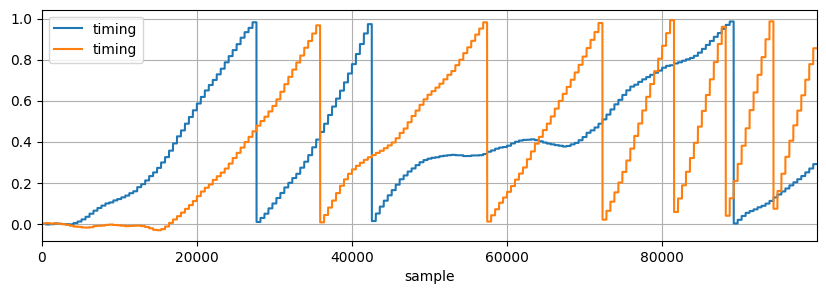

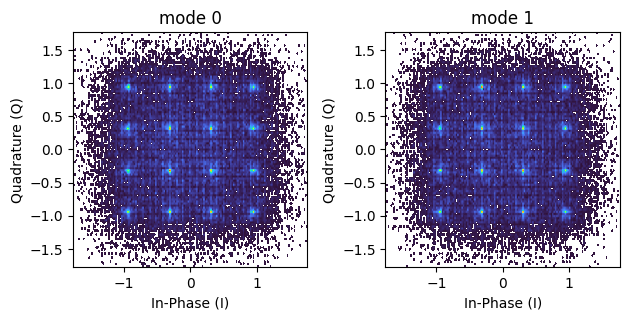

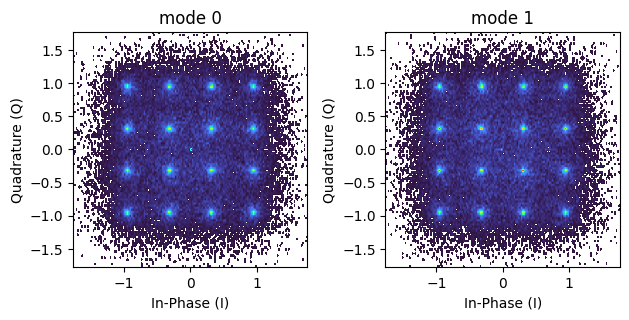

In [67]:
# simulation parameters
SpS = 16          # samples per symbol
M = 16            # order of the modulation format
Rs = 32e9         # Symbol rate 
Fs = SpS*Rs       # Sampling frequency in samples/second
Ts = 1/Fs         # Sampling period
ppm = -200        # Deviation of the ADC sampling rate in ppm

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*1e5))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization
symbTx = symbTx.reshape(-1,2)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rc', SpS, N=4001, alpha=0.01)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# Calculate ADC sampling rate from clock ppm deviation
Fs_adc = 2*Rs*(1 + ppm/1e6)
ppm_meas = (Fs_adc-2*Rs)/(2*Rs)*1e6
print(f'ADC sampling rate = {Fs_adc/1e9:.5f} GS/s')
print(f'ADC sampling clock drift (ΔFs) = {ppm_meas:.2f} ppm')

# ADC input parameters
paramADC = parameters()
paramADC.Fs_in = Fs
paramADC.Fs_out = Fs_adc
paramADC.jitter_rms = 400e-15
paramADC.nBits = 8
paramADC.Vmax = np.max(sigTx.real)
paramADC.Vmin = np.min(sigTx.real)
paramADC.AAF = True
paramADC.N = 1001

sigRx = adc(sigTx, paramADC)

# clock recovery with Godard algorithm
paramCR = parameters() 
paramCR.Fs = 2*Rs
paramCR.NFFT = 1024
paramCR.ki = 1e-3
paramCR.kp = 2e-6

freqResponse = np.ones(paramCR.NFFT//2)
outCLK, ted_values = godardClockRecovery(sigRx, freqResponse, paramCR)

# plot curve of estimated timmig error over time
plt.figure(figsize=(10, 3))
plt.plot(ted_values, label = 'timing')
plt.xlabel('sample')
plt.xlim([0, len(ted_values)])
plt.grid()
plt.legend()

# plot received constellations without and with clock recovery
discard = 5000
pconst(sigRx[discard::2], pType='fancy');
pconst(outCLK[discard::2], pType='fancy');

# symbRx = outCLK[0::2,:].copy()
# BER, _, _ = fastBERcalc(symbRx[discard:-discard,:], symbTx[discard:-discard,:], M, 'qam')

# for indMode in range(BER.shape[0]):
#     print(f'Mode {indMode}: BER = {BER[indMode]:.2e}')

# Referências

[1] Digital Coherent Optical Systems, Architecture and Algorithms

[2] L. Erup, F.M. Gardner, R.A. Harris, Interpolation in digital modems II. Implementation and performance. IEEE Trans. Commun. 41(6), 998–1008 (1993)

[3] C. Farrow, A continuously variable digital delay element, in IEEE International Symposium on Circuits and Systems, vol. 3 (1988), pp. 2641–2645

[4] F. Gardner, A BPSK/QPSK timing-error detector for sampled receivers. IEEE Trans. Commun. 34(5), 423–429 (1986)

[5] N. Stojanovic, C. Xie, Y. Zhao, B. Mao, N. Gonzalez, J. Qi, N. Binh, Modified Gardner phase detector for Nyquist coherent optical transmission systems, in Proceedings of Optical Fiber Communication Conference and National Fiber Optic Engineers Conference (OFC/NFOEC)
(Optical Society of America, America, 2013), p. JTh2A.50. [http://www.osapublishing.org/abstract.cfm?URI=OFC-2013-JTh2A.50](http://www.osapublishing.org/abstract.cfm?URI=OFC-2013-JTh2A.50)

[6] D. Godard, Passband timing recovery in an all-digital modem receiver. IEEE Trans. Commun. 26(5), 517–523 (1978)

[7] X. Zhou, X. Chen, W. Zhou, Y. Fan, H. Zhu, Z. Li, All-digital timing recovery and adaptive equalization for 112-Gbit/s POLMUX-NRZ-DQPSK optical coherent receivers. IEEE/OSA J. Opt. Commun. Networking 2(11), 984–990 (2010)